# Working with Tensorflow and Tensorflow datasets



In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds

List all the available datasets

In [2]:
tfds.list_builders()


['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiabank',
 'diabetic_retinopathy_detection',
 'div2k',
 'dmlab',
 'downsampled_imagenet',
 

# Dataset Information 

We will first use `tfds.builder` to obtain information related to a dataset like MNIST. Take a look at the available information for this dataset, especially the available features (`features`) and the total number of examples (`total_num_examples`).


In [3]:
builder = tfds.builder('mnist')
print(builder.info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



## Features

In [4]:
builder = tfds.builder('mnist')
print(builder.info.features)

FeaturesDict({
    'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


### Label details

In [5]:
builder = tfds.builder('mnist')

#Number of classes
print(builder.info.features["label"].num_classes)

# Class names
print(builder.info.features["label"].names)

# Get the number equiavalent to a label
print(builder.info.features["label"].str2int('8'))

#shape 
print(builder.info.features.shape)

#type of label
print(builder.info.features["label"].dtype)

10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
8
{'image': (28, 28, 1), 'label': ()}
<dtype: 'int64'>


### Features of different datasets

Remove the `break` from the following code and see the available features from the different datasets.

In [6]:
for dataset in tfds.list_builders():
  builder = tfds.builder(dataset)
  print(f"Name: {{0}}\n description: {{1}}".format(builder.info.name, builder.info.description))
  print(f"Name: {{0}}".format(builder.info.features))
  break

Name: abstract_reasoning
 description: Procedurally Generated Matrices (PGM) data from the paper Measuring Abstract Reasoning in Neural Networks, Barrett, Hill, Santoro et al. 2018. The goal is to infer the correct answer from the context panels based on abstract reasoning.

To use this data set, please download all the *.tar.gz files from the data set page and place them in ~/tensorflow_datasets/abstract_reasoning/.

$R$ denotes the set of relation types (progression, XOR, OR, AND, consistent union), $O$ denotes the object types (shape, line), and $A$ denotes the attribute types (size, colour, position, number). The structure of a matrix, $S$, is the set of triples $S={[r, o, a]}$ that determine the challenge posed by a particular matrix.
Name: FeaturesDict({
    'answers': Video(Image(shape=(160, 160, 1), dtype=tf.uint8)),
    'context': Video(Image(shape=(160, 160, 1), dtype=tf.uint8)),
    'filename': Text(shape=(), dtype=tf.string),
    'meta_target': Tensor(shape=(12,), dtype=tf.

## Loading a dataset

Let's start with loading the MNIST dataset for handwriting recognition


In [7]:
ds = tfds.load('mnist', split='train', shuffle_files=True)
assert isinstance(ds, tf.data.Dataset)
print(ds)


<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>


Iterate over a dataset. Each entry in the dataset has 2 parts: image of a handwritten digit and the associated label.

In [8]:
for example in ds:  # example is `{'image': tf.Tensor, 'label': tf.Tensor}`
  print(list(example.keys()))
  image = example["image"]
  label = example["label"]
  print(image.shape, label)
  break


['image', 'label']
(28, 28, 1) tf.Tensor(4, shape=(), dtype=int64)


Obtain a tuple

In [9]:
ds = tfds.load('mnist', split='train',  as_supervised=True)

for image, label in ds:  # example is (image, label)
  print(image)
  print(label)
  break


tf.Tensor(
[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  

## Visualization

Another way is to use `take()` and pass a number **n** to select **n** examples from the dataset. Passing `with_info` with True helps to create the dataframe with necessary information for the visualization. Try changing the value of `with_info` to False and see the errors. 

In [10]:
ds, info = tfds.load('mnist', split='train', with_info=True)

tfds.as_dataframe(ds.take(1), info)


,image,label
0,,4


Change the parameter value of `ds.take()`.

In [11]:
ds, info = tfds.load('mnist', split='train', with_info=True)

tfds.as_dataframe(ds.take(10), info)


,image,label
0,,4
1,,1
2,,0
3,,7
4,,8
5,,1
6,,2
7,,7
8,,1
9,,6


## Splitting datasets for training and testing

For tasks like classification, it is important to classify the data for training and testing. There are several ways it can be done. In the following example, we display the information of the dataset after the loading of the dataset. Take a look at different information like features, splits, total_num_examples etc.

In [12]:
(ds_train, ds_test), info = tfds.load('mnist', split=['train', 'test'], with_info=True)
print(info)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



To create a training dataset from the first 80% of the training split.

In [13]:
ds_train, info = tfds.load('mnist', split='train[80%:]', with_info=True)

## Applying modifications

In [14]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

(ds_train, ds_test), info = tfds.load('mnist', split=['train', 'test'],  as_supervised=True, with_info=True)
ds_train = ds_train.map(normalize_img)
ds_test = ds_test.map(normalize_img)

## Batches

For testing and training, it is important to create batches. Make use of `batch()` for creating batches of the specified size. For example, the code below will create batches of 128 samples.

In [15]:
(ds_train, ds_test), info = tfds.load('mnist', split=['train', 'test'],  as_supervised=True, with_info=True)
ds_train = ds_train.batch(128)
ds_test = ds_test.batch(128)
print(ds_train)
print(ds_test)

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.uint8, tf.int64)>
<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.uint8, tf.int64)>


## Building a training model

In [16]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=info.features["image"].shape),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(0.001),
    metrics=['accuracy'],
)


## Model Summary

In [17]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None


## Visualizing the model

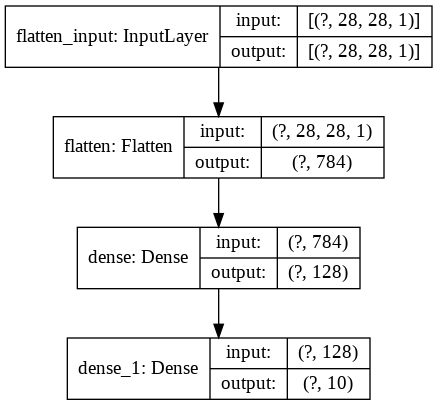

In [18]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

## Training

In [19]:
history = model.fit(ds_train, epochs=10, batch_size=10,validation_data=ds_test)

Epoch 1/10
469/469 [==============================] - 9s 18ms/step - loss: 5.4410 - accuracy: 0.8619 - val_loss: 1.1797 - val_accuracy: 0.8982
Epoch 2/10
469/469 [==============================] - 2s 4ms/step - loss: 0.7434 - accuracy: 0.9038 - val_loss: 0.5938 - val_accuracy: 0.9096
Epoch 3/10
469/469 [==============================] - 2s 4ms/step - loss: 0.3883 - accuracy: 0.9271 - val_loss: 0.5050 - val_accuracy: 0.9262
Epoch 4/10
469/469 [==============================] - 2s 3ms/step - loss: 0.2713 - accuracy: 0.9404 - val_loss: 0.4197 - val_accuracy: 0.9339
Epoch 5/10
469/469 [==============================] - 2s 3ms/step - loss: 0.2079 - accuracy: 0.9496 - val_loss: 0.4139 - val_accuracy: 0.9350
Epoch 6/10
469/469 [==============================] - 2s 3ms/step - loss: 0.1795 - accuracy: 0.9549 - val_loss: 0.3825 - val_accuracy: 0.9404
Epoch 7/10
469/469 [==============================] - 2s 3ms/step - loss: 0.1574 - accuracy: 0.9603 - val_loss: 0.3579 - val_accuracy: 0.9417
Epoch

## History of training

In [20]:
# list different data in history
for histinfo in history.history.keys():
  print(f"{histinfo}: {{0}}".format(history.history[histinfo]))

loss: [5.441022872924805, 0.7433711886405945, 0.3883182108402252, 0.27132493257522583, 0.20790787041187286, 0.17945870757102966, 0.15738992393016815, 0.1429973989725113, 0.13735821843147278, 0.1329723298549652]
accuracy: [0.8619333505630493, 0.9038333296775818, 0.9271000027656555, 0.9403666853904724, 0.9495999813079834, 0.954883337020874, 0.9602833390235901, 0.9627000093460083, 0.9629666805267334, 0.9651333093643188]
val_loss: [1.1797374486923218, 0.5937974452972412, 0.5050421357154846, 0.41965728998184204, 0.4138852059841156, 0.38248786330223083, 0.3579118847846985, 0.3634081780910492, 0.32489171624183655, 0.3359513282775879]
val_accuracy: [0.8981999754905701, 0.909600019454956, 0.9261999726295471, 0.933899998664856, 0.9350000023841858, 0.9404000043869019, 0.9416999816894531, 0.9434000253677368, 0.945900022983551, 0.9490000009536743]


Visualizing the history

Text(0.5, 1.0, 'History of Training and Validation Accuracy across epochs')

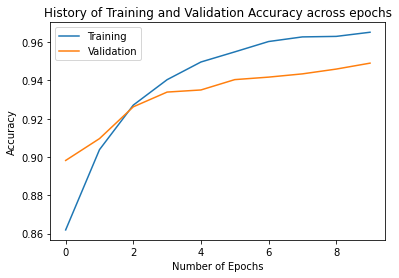

In [21]:
import matplotlib.pyplot as plot

plot.plot(history.history["accuracy"], label="Training")
plot.plot(history.history["val_accuracy"], label="Validation")
plot.legend(loc="upper left")
plot.ylabel("Accuracy")
plot.xlabel("Number of Epochs")
plot.title("History of Training and Validation Accuracy across epochs")

Text(0.5, 1.0, 'History of Training and Validation Loss across epochs')

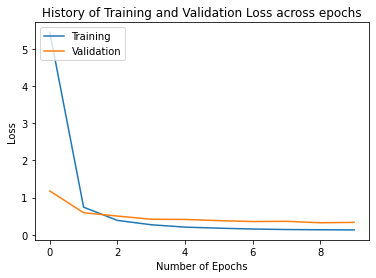

In [22]:
plot.plot(history.history["loss"], label="Training")
plot.plot(history.history["val_loss"], label="Validation")
plot.legend(loc="upper left")
plot.ylabel("Loss")
plot.xlabel("Number of Epochs")
plot.title("History of Training and Validation Loss across epochs")

In [23]:
loss, accuracy = model.evaluate(ds_test, verbose=0)
print(f"accuracy: {accuracy} and loss:{loss}")

accuracy: 0.9490000009536743 and loss:0.3359513282775879


## Prediction

In [24]:
# Creating a dataset for testing
ds_test = tfds.load('mnist', split='test[20%:]',  as_supervised=True, shuffle_files=True)

# Creating a probability model for different classes for obtaining the probabilty
# for each class
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

# Creating batches
ds_test_batch = ds_test.batch(128)

# Prediction
predictions = probability_model.predict(ds_test_batch)


Obtaining the number of predictions made

In [25]:
print(len(predictions))

8000


Check the probability values for second prediction

In [26]:
print(predictions[1])

[0.085746   0.085746   0.085746   0.085746   0.08867148 0.085746
 0.085746   0.08574653 0.0857647  0.22534133]


Get the class with the highest probability

In [27]:
import numpy as np
print(np.argmax(predictions[1]))


9


Get the class with the highest probability for all the classes

In [28]:
predictedlabels = [np.argmax(predictions[i]) for i in range(len(predictions))]

Get the actual class or label from the test dataset.

In [29]:
data = ds_test.as_numpy_iterator()
testdata = list(data)
labels = [testdata[i][1] for i in range(len(testdata))]
print(labels[1])

9


Evaluate the prediction using a confusion matrix

In [30]:
confusionmatrix = tf.math.confusion_matrix(labels, predictedlabels, num_classes=10)
print(confusionmatrix)

tf.Tensor(
[[757   0   0   1   1   3   9   3   1   2]
 [  0 901   3   2   1   1   1   0   6   1]
 [  2   5 762  19   2   0   3   6  10   1]
 [  1   3  12 747   1  13   4   5  16  12]
 [  0   1   5   1 755   0   6   4   6  21]
 [  4   2   2  19   0 669   9   0   7   0]
 [  7   3   0   1  10   8 731   0   3   0]
 [  3   7  12   2   5   0   1 773   7  10]
 [  8   2   7   2   3   9   4   1 730   5]
 [  1   2   1   5  13   5   2   8  13 768]], shape=(10, 10), dtype=int32)


Visualizing the confusion matrix

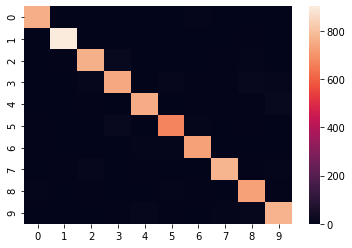

In [31]:
import seaborn as sn

sn.heatmap(confusionmatrix)